In [88]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


path = Path('data')

Metadata contains a uinque id of a sample point with lat, lng, date and split (train/test).

In [89]:
metadata = pd.read_csv(path / 'metadata.csv')
metadata

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


We have to download the satellite, meteo, dem, ... for each point manually :(

In [90]:
train = metadata[metadata.split == 'train']
test = metadata[metadata.split == 'test']

len(train), len(test)

(17060, 6510)

For each point we know the density and severty (we have to predict the severity, not the density).

In [91]:
labels = pd.read_csv(path / 'train_labels.csv')
assert len(train) == len(labels)
labels

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0
...,...,...,...,...
17055,zzsv,south,3,113125.0
17056,zzuq,south,3,175726.0
17057,zzwo,midwest,2,48510.0
17058,zzwq,south,1,1271.0


In [92]:
train_data = train.join(labels.set_index('uid'), on='uid')
train_data

,uid,latitude,longitude,date,split,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0
2,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0
5,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0
...,...,...,...,...,...,...,...,...
23562,zzsv,38.707825,-75.080867,2018-06-27,train,south,3,113125.0
23564,zzuq,35.794000,-79.015368,2015-08-06,train,south,3,175726.0
23566,zzwo,39.792190,-99.971050,2017-06-19,train,midwest,2,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,south,1,1271.0


In [93]:
train_data.describe()

,latitude,longitude,severity,density
count,17060.000000,17060.000000,17060.000000,1.706000e+04
mean,37.307321,-89.744762,2.145955,1.074537e+06
std,2.383112,17.194386,1.199942,6.836693e+06
min,26.389430,-124.179200,1.000000,0.000000e+00
25%,35.705383,-97.101940,1.000000,4.066000e+03
50%,35.980000,-79.203063,2.000000,3.270975e+04
75%,38.160200,-79.011995,3.000000,4.849192e+05
max,48.907060,-68.065070,5.000000,8.046675e+08


In [94]:
train_data.severity.value_counts()

1    7497
4    3547
2    3239
3    2719
5      58
Name: severity, dtype: int64

[]

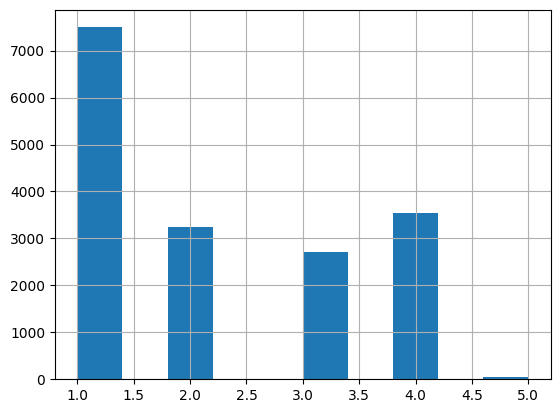

In [95]:
train_data.severity.hist()
plt.plot()

The dataset is not balanced :(

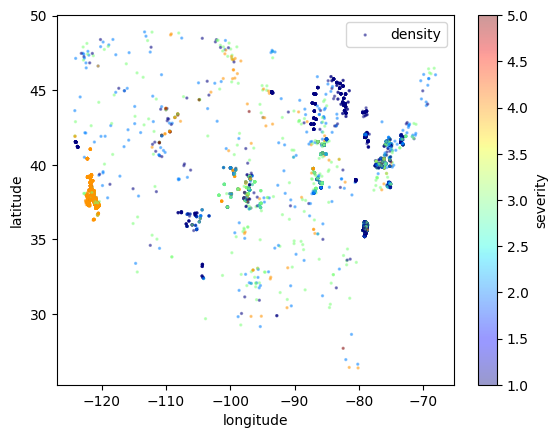

In [96]:
train_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=2, label="density", c="severity", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

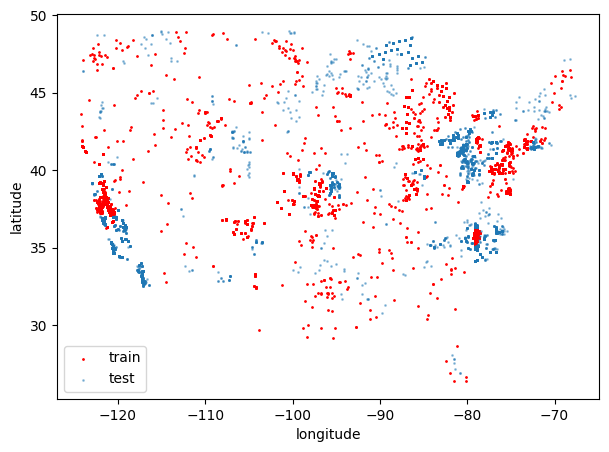

In [97]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
train_data.plot(kind="scatter", x="longitude", y="latitude", s=1, color="red", ax=ax, label="train")
test.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=1, ax=ax, label="test")
plt.show()

In [98]:
train_split, val_split = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.severity)

len(train_split), len(val_split)

(13648, 3412)

[]

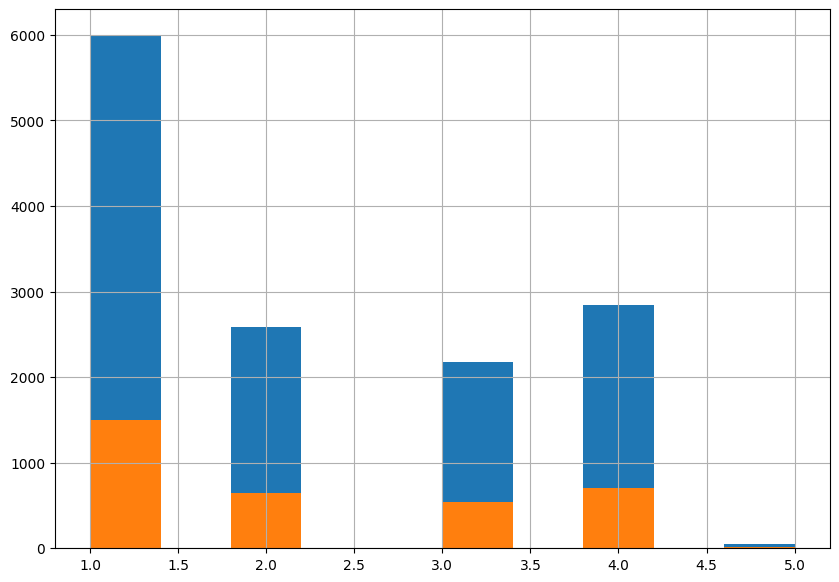

In [99]:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
train_split.severity.hist(ax =ax, label='train')
val_split.severity.hist(ax =ax, label='val')
plt.plot()

In [100]:
train_split.to_csv(path / 'train.csv', index=False)
val_split.to_csv(path / 'val.csv', index=False)

Balance train split

In [101]:
# balance the training set
# upsample the minority classes to match the majority class

from sklearn.utils import resample

train = pd.read_csv(path / 'train.csv')
majority = train[train.severity == 1]
for i in range(2, 6):
	this_labels = train[train.severity == i]
	df = resample(this_labels, replace=True, n_samples=len(majority) - len(this_labels), random_state=42)
	train = pd.concat([train, df])

train


,uid,latitude,longitude,date,split,region,severity,density
0,rduy,35.837000,-79.001000,2015-08-06,train,south,3,728075.00
1,nmkw,35.865797,-78.804114,2015-09-24,train,south,2,42407.00
2,rqwt,37.320400,-120.983000,2018-04-10,train,west,4,6675000.00
3,xyde,37.261600,-120.906000,2017-10-10,train,west,4,5480000.00
4,bbzd,35.794000,-79.014330,2015-06-22,train,south,2,73582.00
...,...,...,...,...,...,...,...,...
2801,dulv,37.386500,-121.969000,2018-07-17,train,west,5,12415000.00
7431,mbbo,39.399200,-99.424810,2018-06-25,train,midwest,5,29767500.00
13427,jljl,43.176850,-108.614650,2021-09-14,train,west,5,18485452.82
4675,epww,39.399200,-99.424810,2018-08-13,train,midwest,5,59535000.00


In [102]:
train.severity.value_counts()

3    5998
2    5998
4    5998
1    5998
5    5998
Name: severity, dtype: int64

[]

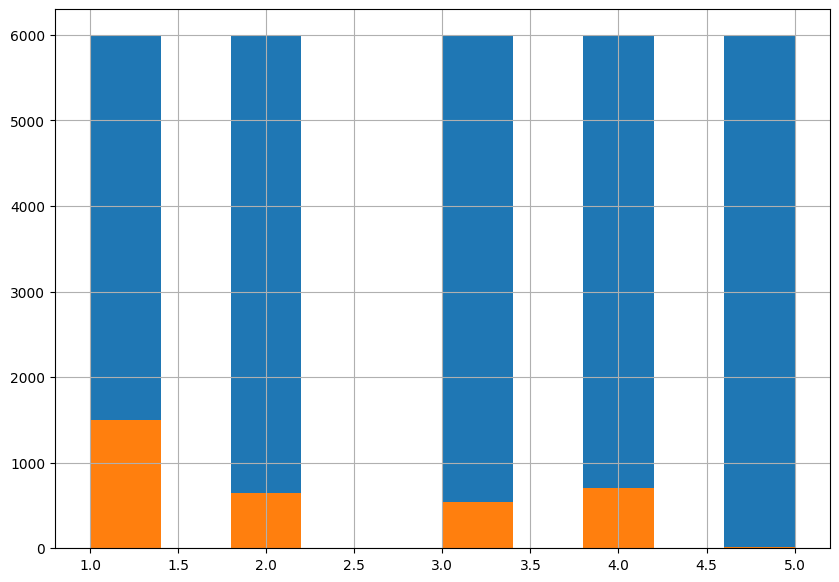

In [103]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
train.severity.hist(ax =ax, label='train')
val_split.severity.hist(ax =ax, label='val')
plt.plot()

In [104]:
train.to_csv(path / 'train_balanced.csv', index=False)